<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/B1-Pandas_Reading_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pandas

## Setup and preliminaries

Install the necessary libraries to connect to MySQL and to read Excel files

In [1]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic xlrd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

Pandas offers the ability to read and write from/to many different data types. We list a few examples below, and we have a [small example](https://github.com/ipeirotis/dealing_with_data/blob/master/03-Pandas/E2-Reading_from_Web_Pages.ipynb) where we read directly tables from web pages. The [official documentation](https://pandas.pydata.org/docs/reference/io.html) has the full list.

## Loading data from MySQL Server using the `read_sql` command

### DOH Restaurant Inspections

We start by setting up the connection to the MySQL server that we want to use.

In [5]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2015',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

We fetch the results of the query using the `read_sql` command.

In [ ]:
# This query returns back the restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE
		FROM doh_restaurants.restaurants R

'''

with engine.connect() as connection:
	restaurants = pd.read_sql(text(sql), con=connection)


When you run your query using Pandas, you get back a kind of object called a DataFrame, which is made up of rows and columns. Let's take a look at how the object looks like:

In [ ]:
restaurants

# Load a table from Google BigQuery

<Axes: xlabel='complaint_date'>

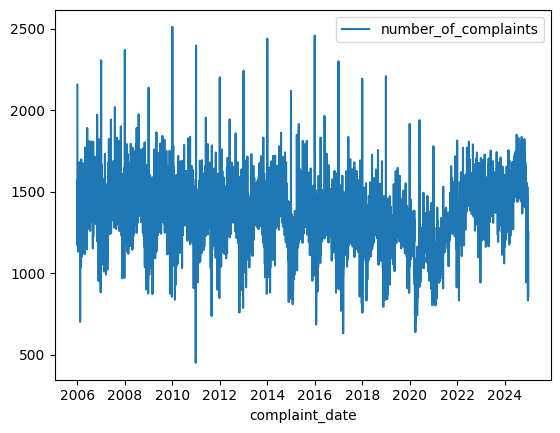

In [14]:
# prompt: I want to connect to the BigQuery dataset nyu-datasets.nypd_complaints
# and run a SQL query on the nypd table, counting the number of complaints per
# date (the CMPLNT_FR contains the datetime of the complaint)

!pip install -U -q google-cloud-bigquery
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

# Important: Replace with your GCP project ID
project_id = 'ipeirotis-hrd'
client = bigquery.Client(project=project_id)

query = """
SELECT
  DATE(CMPLNT_FR) AS complaint_date,
  COUNT(*) AS number_of_complaints
FROM
  `nyu-datasets.nypd_complaints.nypd`
WHERE
  CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR < '2025-01-01'
GROUP BY
  complaint_date
ORDER BY
  complaint_date
"""

complaints_by_date = client.query(query).to_dataframe()

complaints_by_date.plot(
    x='complaint_date',
    y='number_of_complaints',
    kind='line'
)

## Loading a CSV file using the `read_csv` command

### 2018 Central Park Squirrel Census

Let's get the [2018 Central Park Squirrel Census](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw)

In [ ]:
# Option 1: Download the CSV dataset using
# the "!curl" command (a Linux command line)
# To get the URL, go to "Export => CSV" and then copy the link
!curl https://data.cityofnewyork.us/api/views/vfnx-vebw/rows.csv?accessType=DOWNLOAD -o squirrel_census.csv
squirrels = pd.read_csv("squirrel_census.csv")

In [ ]:
# Option 2: Read the URL directly
# Fine for small datasets, not great when you have a big dataset and
# may want to reload it repeatedly
url = 'https://data.cityofnewyork.us/api/views/vfnx-vebw/rows.csv?accessType=DOWNLOAD'
squirrels = pd.read_csv(url)

In [ ]:
squirrels

### Data maniputation techniques (optional)

Below, we apply a variety of data maniputation techniques to improve the dataset.

In [ ]:
# The command below adds underscores in all column names and capitalizes them
cols = squirrels.columns.map(lambda x: x.replace(' ', '_').upper())
squirrels.columns = cols

In [ ]:
# See https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
# for the meaning of the "format" variable
squirrels['DATE'] = pd.to_datetime(squirrels['DATE'], format='%m%d%Y')

In [ ]:
# Delete the column "LAT/LONG"
squirrels = squirrels.drop(["LAT/LONG"], axis = "columns")

In [ ]:
squirrels

## Loading an Excel file using the `read_excel` command

### Titanic Dataset

Let's now load the [Titanic dataset](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active) from an Excel file.



In [ ]:
titanic_url = 'https://storage.googleapis.com/datasets_nyu/titanic.xls'
titanic = pd.read_excel(titanic_url)
titanic

### Data Dictionary for DOH Restaurants dataset

The [DOHMH New York City Restaurant Inspection Results](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j) contains a pointer to an Excel file called the "data dictionary". Let's download it and see how it looks like.

In [ ]:
url = 'https://data.cityofnewyork.us/api/views/43nn-pn8j/files/ec33d2c8-81f5-499a-a238-0213a38239cd?download=true&filename=RestaurantInspectionDataDictionary_09242018.xlsx'

In [ ]:
restaurants_data_dictionary = pd.read_excel (url, sheet_name=1, header=1);

In [ ]:
restaurants_data_dictionary

In [ ]:
# Rename the columns
restaurants_data_dictionary.columns = ['Column_Name', 'Description', 'Code_Definitions', 'Notes']

In [ ]:
# Drop the first line
restaurants_data_dictionary = restaurants_data_dictionary.drop(0, axis='index')

In [ ]:
restaurants_data_dictionary

## Loading a "Fixed Width" file using the `read_fwf` command

### Accidental Deaths in the USA

This [dataset](https://storage.googleapis.com/datasets_nyu/acc-deaths.txt) is in "fixed width" format  and contains the monthly totals of accidental deaths in the USA.

In [ ]:
deaths = pd.read_fwf("https://storage.googleapis.com/datasets_nyu/acc-deaths.txt")
deaths

### Data maniputation techniques (optional)

Below, we apply a variety of data maniputation techniques to improve the dataset.

#### Melt and Pivot_Table

Now we want to take the month-columns, and convert the file into a file with the format `<date>, <value>`.

The command for this is the [`melt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) command. (For the opposite operation, use the pivot_table function.)

In [ ]:
unpivoted_deaths = pd.melt(deaths, id_vars=['Year'],
        value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        var_name='Month', value_name='Deaths')
unpivoted_deaths.head(10)

In [ ]:
# The opposite of melt:
unpivoted_deaths.pivot_table(
    index='Year',
    columns='Month',
    values = 'Deaths'
)

In [ ]:
# Now, we want to merge the month and year columns, to create a Date column.
# Notice the use of .astype(str) function that converts the int64 datatype into a string.
# Without that function, we get an error message that we cannot add an integer (Year) with a string (Month)
unpivoted_deaths["Date"] = unpivoted_deaths["Month"] + "-" + unpivoted_deaths["Year"].astype(str)
unpivoted_deaths

In [ ]:
# Convert the date column to a proper DateTime data type
unpivoted_deaths["Date"] = pd.to_datetime(unpivoted_deaths["Date"], format='%b-%Y')
unpivoted_deaths

In [ ]:
# Now, that we have the Date column, we can delete the month and year columns.
# Notice the axis='columns' part: this means that we drop a column with that name.
# If we used axis='rows', then Pandas would have been looking for a row with that key to drop.

unpivoted_deaths = unpivoted_deaths.drop(["Month","Year"], axis='columns')


In [ ]:
# And now we convert the Date to be an index, so that it can be used as the x-axis for plotting the series.
unpivoted_deaths = unpivoted_deaths.set_index(keys="Date")


In [ ]:
# Notice that the dates are not in order (we get the January's for all the
# years first, then the February's etc). While this is not an issue with
# plotting, this can be an issue for other types of analyses.
# For this reason, we sort the index:

unpivoted_deaths = unpivoted_deaths.sort_index()

In [ ]:
unpivoted_deaths.plot()

## Loading Tables from HTML Pages using the `read_html` command

### Retrieve Country Population From Wikipedia

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)'

# The "read_html" returns back a list of "dataframes", one for each table in the web page
df_list = pd.read_html(
            url, # Specify the page
            match='Population', # Write a pattern that is unique to the table we are interested in
            header=0 # which line of the table to use as a header
        )

len(df_list) # check how many tables match

In [ ]:
# We get the first table in the list, which contains the population of the countries
df_population = df_list[0]
df_population

In [ ]:
# Remove the footnote notations in square brackets (eg., "[4]")
# The code uses regular expressions for removing the unecessary text
df_population = df_population.replace(
    to_replace = r'(.*)\[.\]',
    value = r'\1',
    regex=True
)

In [ ]:
# Rename the columns
df_population.columns = ['Country', 'Region', 'Subegion', 'Population_2022', 'Population_2023', 'Change']

In [ ]:
# Keep only the columns we need
df_population = df_population.filter( items = ['Country', 'Population_2023'] )

In [ ]:
df_population

### Retrieve Life Expectancy From Wikipedia

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy'
df_list = pd.read_html(
            url, # Specify the page
            match='Life expectancy at birth', # Write a pattern that is unique to the table we are interested in
            header=0 # which line of the table to use as a header
        )

len(df_list) # check how many tables match


In [ ]:
df_who=df_list[0] # get the first of the tables
df_who


In [ ]:
# Keep only two columns
df_who = df_who.filter( items = ['Countries and regions', 'Life expectancy at birth'] )
# Delete the first two lines of the dataset
df_who = df_who.drop([0])
df_who

In [ ]:
# Convert the 'Life expectancy at birth' column to numeric
# and store it in a column called "Life_Expectancy"
df_who['Life_expectancy'] = pd.to_numeric(df_who['Life expectancy at birth'])
# Delete the original column
df_who = df_who.drop('Life expectancy at birth', axis='columns')
df_who

In [ ]:
df_who